# Transfer from walking to other tasks

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import ranksums
from bbbqd.body.body_utils import compute_body_encoding_function
import numpy as np
%matplotlib inline

In [7]:
tasks = ["BridgeWalker-v0", "CustomCarrier-v0", "PlatformJumper-v0", "CaveCrawler-v0",
         "BidirectionalWalker-v0",

         # object manipulation
         "CustomPusher-v0",
         # ("Thrower-v0" # gives error
         "BeamToppler-v0",
         "Pusher-v1",
         # ("Carrier-v1" # gives error
         "Catcher-v0",
         # ("Slider-v0" # gives error
         # ("Lifter-v0" # gives error

         # all climb give error because too narrow

         # locomotion
         "UpStepper-v0",
         "DownStepper-v0",
         "ObstacleTraverser-v0",
         "ObstacleTraverser-v1",
         "Hurdler-v0",
         "GapJumper-v0",
         "Traverser-v0",

         # misc
         "Flipper-v0",
         "Jumper-v0",
         "Balancer-v0",
         # ("Balancer-v1" # gives error

         # shape change
         "AreaMaximizer-v0",
         "AreaMinimizer-v0",
         "WingspanMazimizer-v0",
         "HeightMaximizer-v0",
         ]

In [9]:
evo_dfs = []
sampling = "all"
for task in tasks:
    processed_task = task.replace("-v0", "").lower()
    for seed in range(10):
        try:
            tmp_df = pd.read_csv(f"../results/me/evo-body-10x10-{processed_task}-{sampling}_{seed}.csv")
            tmp_df["seed"] = seed
            tmp_df["task"] = task
            tmp_df["sampling"] = "evo_me"  # sampling
            tmp_df["repertoire"] = "all"
            evo_dfs.append(tmp_df)


            tmp_df = pd.read_csv(f"../results/ga/evo-body-10x10-{processed_task}_{seed}.csv")
            tmp_df["seed"] = seed
            tmp_df["task"] = task
            tmp_df["sampling"] = "evo_ga"  # sampling
            tmp_df["repertoire"] = "all"
            evo_dfs.append(tmp_df)

        except FileNotFoundError:
            print(task, seed)
evo_df = pd.concat(evo_dfs, ignore_index=True)
evo_df.head()

CaveCrawler-v0 9
BidirectionalWalker-v0 0
BidirectionalWalker-v0 1
BidirectionalWalker-v0 2
BidirectionalWalker-v0 3
BidirectionalWalker-v0 4
BidirectionalWalker-v0 5
BidirectionalWalker-v0 6
BidirectionalWalker-v0 7
BidirectionalWalker-v0 8
BidirectionalWalker-v0 9
CustomPusher-v0 0
CustomPusher-v0 1
CustomPusher-v0 2
CustomPusher-v0 3
CustomPusher-v0 4
CustomPusher-v0 5
CustomPusher-v0 6
CustomPusher-v0 7
CustomPusher-v0 8
CustomPusher-v0 9
BeamToppler-v0 0
BeamToppler-v0 1
BeamToppler-v0 2
BeamToppler-v0 3
BeamToppler-v0 4
BeamToppler-v0 5
BeamToppler-v0 6
BeamToppler-v0 7
BeamToppler-v0 8
BeamToppler-v0 9
Pusher-v1 0
Pusher-v1 1
Pusher-v1 2
Pusher-v1 3
Pusher-v1 4
Pusher-v1 5
Pusher-v1 6
Pusher-v1 7
Pusher-v1 8
Pusher-v1 9
Catcher-v0 0
Catcher-v0 1
Catcher-v0 2
Catcher-v0 3
Catcher-v0 4
Catcher-v0 5
Catcher-v0 6
Catcher-v0 7
Catcher-v0 8
Catcher-v0 9
UpStepper-v0 0
UpStepper-v0 1
UpStepper-v0 2
UpStepper-v0 3
UpStepper-v0 4
UpStepper-v0 5
UpStepper-v0 6
UpStepper-v0 7
UpStepper-v0 

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,seed,task,sampling,repertoire
0,1.0,1.033856,-2.813630,2.786834,-7.729624,1.269531,5.957031,2.636719,23.280643,2024-06-04 19:39:47.713679,0.0,0,BridgeWalker-v0,evo_me,all
1,2.0,1.033856,-2.283975,8.642919,-10.980222,1.367188,7.714844,3.222656,13.593169,2024-06-04 19:40:01.307147,0.0,0,BridgeWalker-v0,evo_me,all
2,3.0,1.033856,1.529860,15.400932,-9.685629,1.464844,9.082031,3.320312,13.195543,2024-06-04 19:40:14.503131,0.0,0,BridgeWalker-v0,evo_me,all
3,4.0,1.033856,1.782396,20.309895,-9.502535,1.464844,9.863281,3.417969,13.382216,2024-06-04 19:40:27.885777,0.0,0,BridgeWalker-v0,evo_me,all
4,5.0,1.033856,4.763123,26.261871,-11.015659,1.464844,11.132812,3.808594,13.246979,2024-06-04 19:40:41.133130,0.0,0,BridgeWalker-v0,evo_me,all


## Processing time

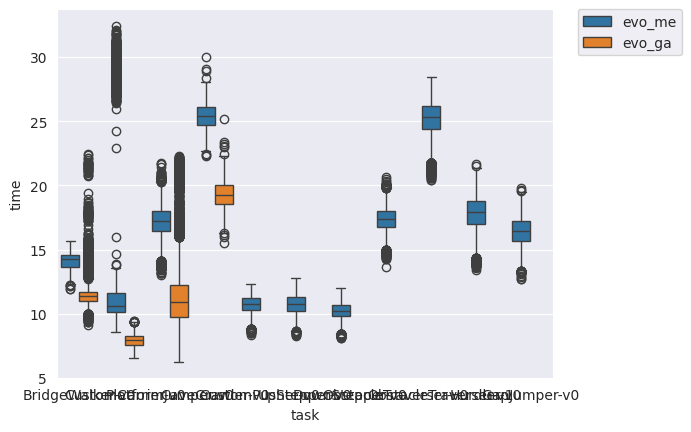

In [10]:
sns.boxplot(
    evo_df[evo_df["iteration"] > 5],
    x="task",
    y="time",
    hue="sampling",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Evolution results

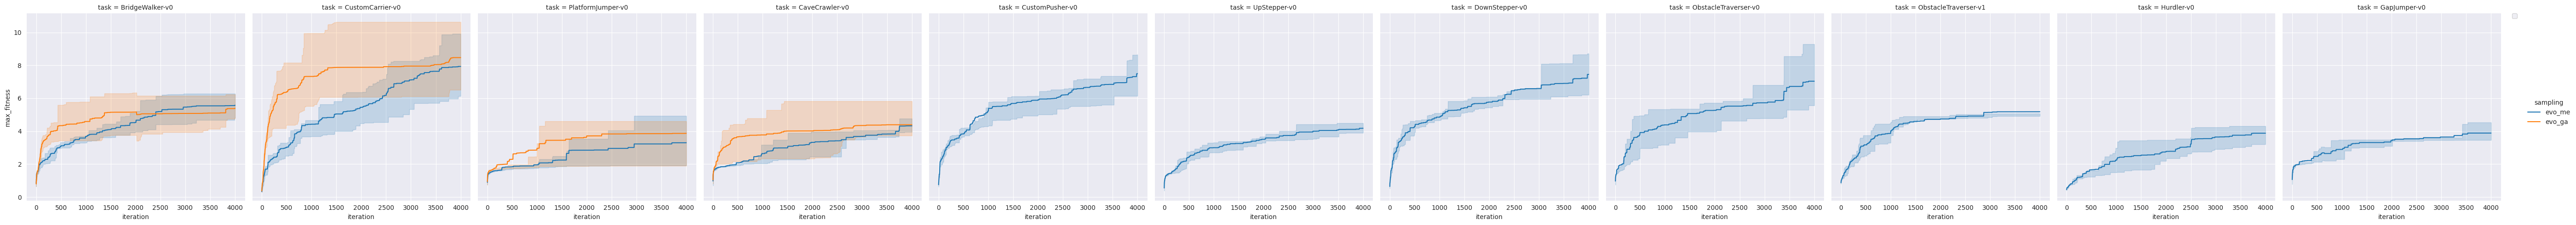

In [11]:
sns.relplot(
    data=evo_df, x="iteration", y="max_fitness", col="task",
    hue="sampling", kind="line", errorbar=("pi", 50),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [12]:
final_evo_df = evo_df[evo_df["iteration"] == max(evo_df["iteration"])][
    ["max_fitness", "coverage1", "coverage2", "coverage3", "task", "seed", "sampling", "repertoire"]]
final_evo_df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.41797,37.988280,BridgeWalker-v0,0,evo_me,all
7999,6.584088,NaN,NaN,NaN,BridgeWalker-v0,0,evo_ga,all
11999,6.262626,16.699219,55.76172,42.871094,BridgeWalker-v0,1,evo_me,all
15999,5.954528,NaN,NaN,NaN,BridgeWalker-v0,1,evo_ga,all
19999,4.975401,21.875000,55.95703,44.433594,BridgeWalker-v0,2,evo_me,all


## Task transfer results

In [13]:
dfs = [final_evo_df]
samplings = ["all", "s1", "s2", "s3"]
repertoires = [f"g{i + 1}" for i in range(3)]
for task in tasks:
    for seed in range(10):
        tmp_df = pd.read_csv(f"../results/transfer/evo-body-10x10_{seed}_{task}.csv")
        tmp_df["seed"] = seed
        tmp_df["task"] = task
        tmp_df["sampling"] = "ga"
        tmp_df["repertoire"] = "all"
        tmp_df["max_fitness"] = tmp_df["max_fitness"].apply(lambda x: float(x.replace("[", "").replace("]", "")))
        dfs.append(tmp_df)

        for sampling in samplings:
            for rep in repertoires:
                tmp_df = pd.read_csv(
                    f"../results/transfer/evo-body-10x10-floor-{sampling}_{seed}_{rep}_best50_{task}.csv")
                tmp_df["seed"] = seed
                tmp_df["task"] = task
                tmp_df["sampling"] = sampling
                tmp_df["repertoire"] = rep
                dfs.append(tmp_df)
df = pd.concat(dfs)
df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.41797,37.988280,BridgeWalker-v0,0,evo_me,all
7999,6.584088,NaN,NaN,NaN,BridgeWalker-v0,0,evo_ga,all
11999,6.262626,16.699219,55.76172,42.871094,BridgeWalker-v0,1,evo_me,all
15999,5.954528,NaN,NaN,NaN,BridgeWalker-v0,1,evo_ga,all
19999,4.975401,21.875000,55.95703,44.433594,BridgeWalker-v0,2,evo_me,all


In [14]:
tasks_extra_data = {
    "BridgeWalker-v0": ("walking", 6.5),
    "BidirectionalWalker-v0": ("walking", 8.5),

    "CustomCarrier-v0": ("object", 10),
    "CustomPusher-v0": ("object", 9.4),
    "Pusher-v1": ("object", 7.5),
    "Catcher-v0": ("object", -1.5),
    "BeamToppler-v0": ("object", 8),

    "UpStepper-v0": ("locomotion", 7.5),
    "DownStepper-v0": ("locomotion", 9),
    "ObstacleTraverser-v0": ("locomotion", 9),
    "ObstacleTraverser-v1": ("locomotion", 4.5),
    "Hurdler-v0": ("locomotion", 4),
    "PlatformJumper-v0": ("locomotion", 5.5),
    "GapJumper-v0": ("locomotion", 7.5),
    "Traverser-v0": ("locomotion", 5.5),
    "CaveCrawler-v0": ("locomotion", 5.5),

    "AreaMaximizer-v0": ("shape", 2.6),
    "AreaMinimizer-v0": ("shape", .95),
    "WingspanMazimizer-v0": ("shape", .8),
    "HeightMaximizer-v0": ("shape", .45),

    "Flipper-v0": ("misc", 45),
    "Jumper-v0": ("misc", 4.5),
    "Balancer-v0": ("misc", .16),
}


def assign_task_type(row):
    return tasks_extra_data[row.task][0]


def assign_expected_reward_type(row):
    return tasks_extra_data[row.task][1]


df["task_type"] = df.apply(assign_task_type, axis=1)
df["task_expected_reward"] = df.apply(assign_expected_reward_type, axis=1)

In [15]:
median_df = df.groupby(["task", "sampling", "repertoire", "task_type", "task_expected_reward"])[
    "max_fitness"].median().reset_index()
median_df.head()

,task,sampling,repertoire,task_type,task_expected_reward,max_fitness
0,AreaMaximizer-v0,all,g1,shape,2.6,0.849104
1,AreaMaximizer-v0,all,g2,shape,2.6,0.601989
2,AreaMaximizer-v0,all,g3,shape,2.6,0.526538
3,AreaMaximizer-v0,ga,all,shape,2.6,0.166012
4,AreaMaximizer-v0,s1,g1,shape,2.6,0.705789


In [16]:
max_df = df.groupby(["task", "task_type", "task_expected_reward"])["max_fitness"].max().reset_index()
max_df["min_solve_reward"] = 0.8 * max_df["task_expected_reward"]
solved_tasks = max_df[max_df["max_fitness"] >= max_df["min_solve_reward"]]["task"].tolist()

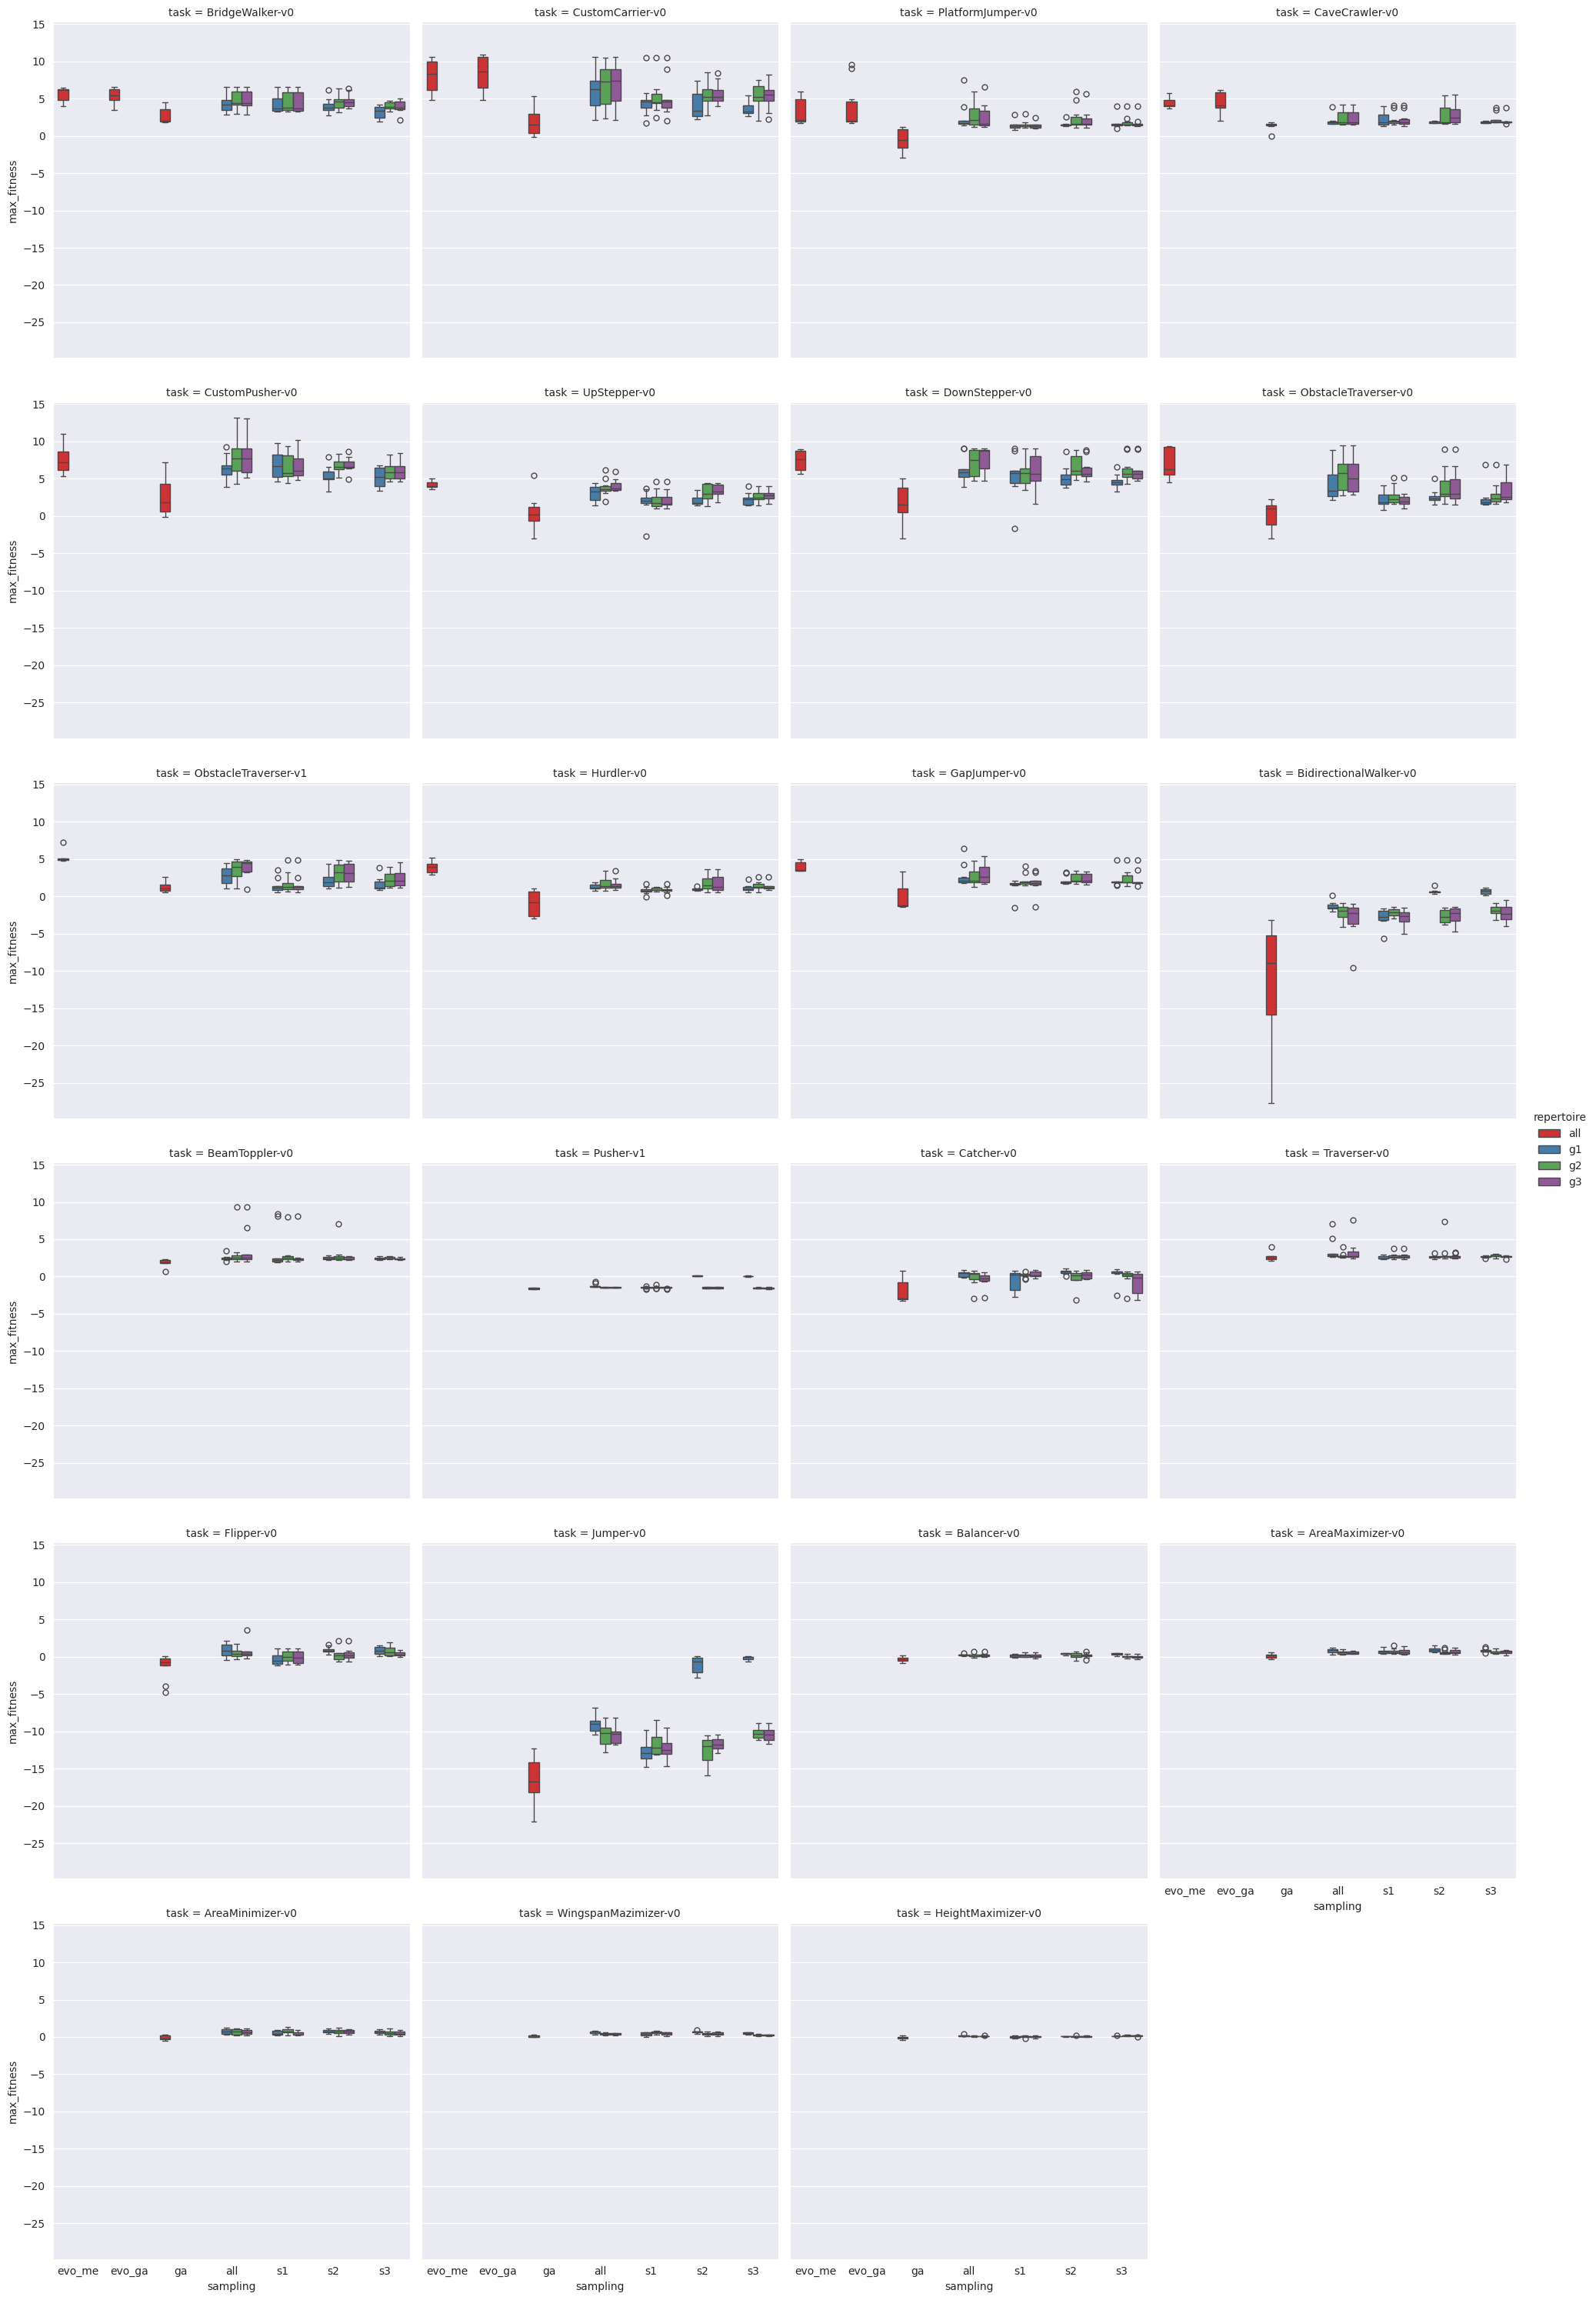

In [17]:
sns.catplot(df,
            x="sampling",
            y="max_fitness",
            col="task",
            col_wrap=4,
            hue="repertoire",
            palette="Set1",
            kind="box",
            )
plt.show()

In [19]:
df_transferred = df[~df["sampling"].str.contains("evo")].reset_index(drop=True)
df_transferred = df_transferred[df_transferred["task"].isin(solved_tasks)]
df_best_transfer_per_evo_way_int = df_transferred.loc[
    df_transferred.groupby(["task", "task_type", "sampling", "seed"])["max_fitness"].idxmax()]
df_best_transfer_per_evo_way_int["rank"] = df_best_transfer_per_evo_way_int.groupby(["task", "task_type"])[
                                               "max_fitness"].rank(
    method="dense",
    ascending=True) / 50.
df_best_transfer_per_evo_way = df_best_transfer_per_evo_way_int.groupby(["task", "task_type", "sampling"])[
    "rank"].mean().reset_index()
df_best_transfer_per_evo_way["task_with_type"] = df_best_transfer_per_evo_way["task_type"].str[0].str.upper() + "-" + \
                                                 df_best_transfer_per_evo_way["task"]
df_best_transfer_per_evo_way.head()

,task,task_type,sampling,rank,task_with_type
0,AreaMinimizer-v0,shape,all,0.696,S-AreaMinimizer-v0
1,AreaMinimizer-v0,shape,ga,0.116,S-AreaMinimizer-v0
2,AreaMinimizer-v0,shape,s1,0.558,S-AreaMinimizer-v0
3,AreaMinimizer-v0,shape,s2,0.656,S-AreaMinimizer-v0
4,AreaMinimizer-v0,shape,s3,0.524,S-AreaMinimizer-v0


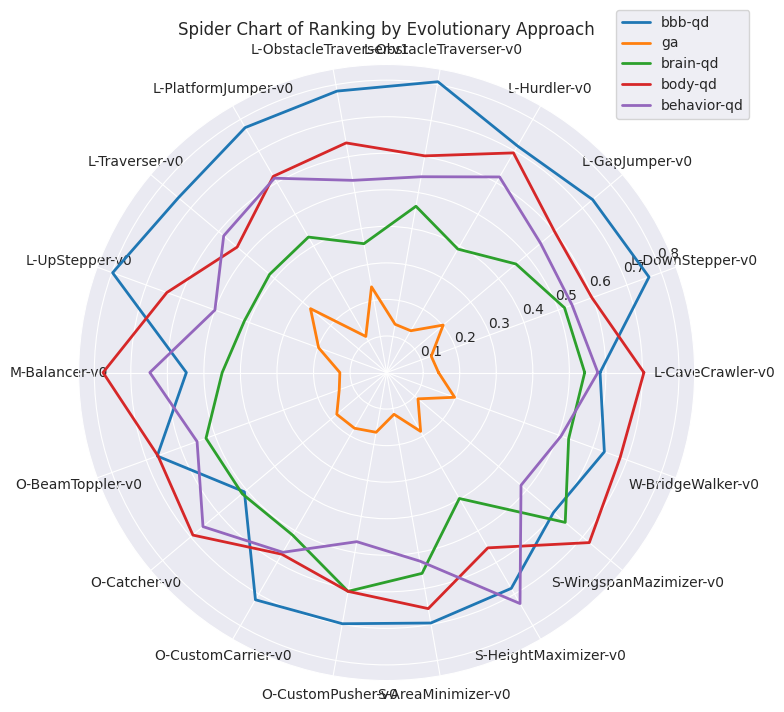

In [20]:
df_best_transfer_per_evo_way_pivot = df_best_transfer_per_evo_way.pivot(index="sampling", columns="task_with_type",
                                                                        values="rank")
qd_mapping = {
    "s1": "brain-qd",
    "s2": "body-qd",
    "s3": "behavior-qd",
    "all": "bbb-qd",
    "ga": "ga"
}
# Replace the sampling names in the DataFrame
df_best_transfer_per_evo_way_pivot.index = df_best_transfer_per_evo_way_pivot.index.map(qd_mapping)
categories = df_best_transfer_per_evo_way_pivot.columns.tolist()  # Tasks as categories
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for sampling, row in df_best_transfer_per_evo_way_pivot.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the shape
    ax.plot(angles, values, label=sampling, linewidth=2)
    # ax.fill(angles, values, alpha=0.25)
# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title("Spider Chart of Ranking by Evolutionary Approach")

plt.show()

In [21]:
df_transferred_qd = df_transferred[df_transferred["sampling"] != "ga"].reset_index(drop=True)
df_transferred_qd["rank"] = df_transferred_qd.groupby(["task", "task_type", "sampling"])["max_fitness"].rank(
    method="dense",
    ascending=True) / 30.
df_transferred_qd = df_transferred_qd[["task", "task_type", "sampling", "repertoire", "rank"]]
df_transferred_qd_mean = df_transferred_qd.groupby(["task", "task_type", "sampling", "repertoire"])[
    "rank"].mean().reset_index()
df_transferred_qd_mean["task_with_type"] = df_transferred_qd_mean["task_type"].str[0].str.upper() + "-" + \
                                           df_transferred_qd_mean["task"]
df_transferred_qd_mean.head()

,task,task_type,sampling,repertoire,rank,task_with_type
0,AreaMinimizer-v0,shape,all,g1,0.500000,S-AreaMinimizer-v0
1,AreaMinimizer-v0,shape,all,g2,0.470000,S-AreaMinimizer-v0
2,AreaMinimizer-v0,shape,all,g3,0.453333,S-AreaMinimizer-v0
3,AreaMinimizer-v0,shape,s1,g1,0.426667,S-AreaMinimizer-v0
4,AreaMinimizer-v0,shape,s1,g2,0.596667,S-AreaMinimizer-v0


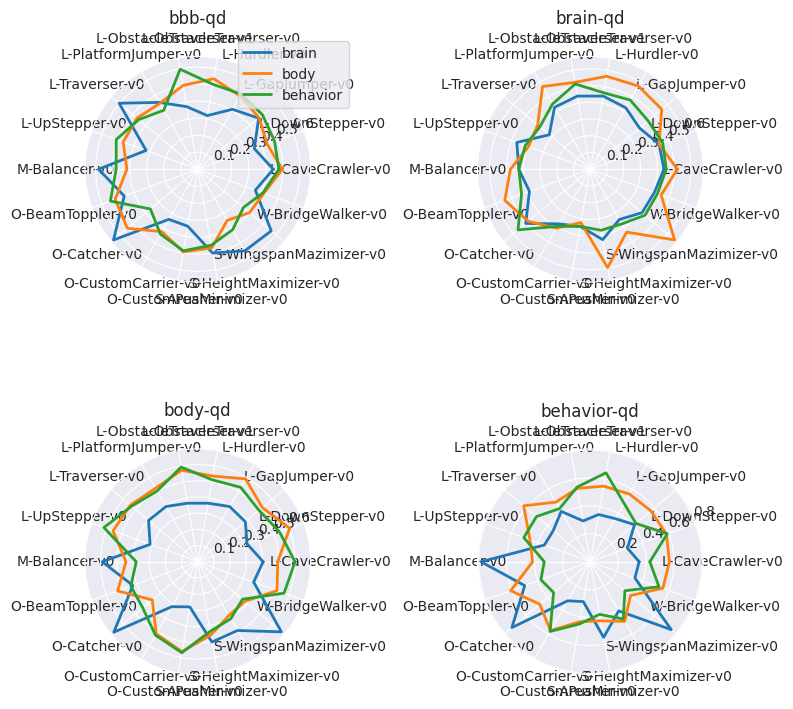

In [23]:
qd_methods = df_transferred_qd_mean["sampling"].unique()
# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw=dict(polar=True))  # 2x2 grid
axes = axes.flatten()  # Flatten the axes for easy iteration

reps_mapping = {
    "g1": "brain",
    "g2": "body",
    "g3": "behavior",
}

# Loop through each group and create a radar chart
for i, group in enumerate(qd_methods):
    ax = axes[i]

    # Filter DataFrame for the current group
    df_group = df_transferred_qd_mean[df_transferred_qd_mean["sampling"] == group]

    # Pivot DataFrame for plotting
    df_pivot = df_group.pivot(index="repertoire", columns="task_with_type", values="rank")

    # Rename samplings in the pivoted DataFrame
    df_pivot.index = df_pivot.index.map(reps_mapping)

    # Get task names and define angles
    categories = df_pivot.columns.tolist()
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the shape

    # Plot each sampling method
    for sampling, row in df_pivot.iterrows():
        values = row.tolist()
        values += values[:1]  # Close the shape
        ax.plot(angles, values, label=sampling, linewidth=2)
        # ax.fill(angles, values, alpha=0.25)

    # Labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(qd_mapping[group])

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Adjust layout
plt.tight_layout()
plt.show()

## Bodies observation

In [43]:
from pathlib import Path
import yaml
from bbbqd.body.body_utils import compute_body_mask, compute_body_float_genome_length

seed = 0
dest_rep = "r2"
for task in tasks:
    print(task.replace("-v0", ""), end=" & &")
    for origin_rep_id in range(1, 4):
        origin_rep = f"g{origin_rep_id}"
        folder = f"../results/transfer/evo-body-10x10-floor-{sampling}_{seed}_{origin_rep}_{task}"
        config = yaml.safe_load(Path(f"{folder}/config.yaml").read_text())
        body_encoding_fn = compute_body_encoding_function(config)
        fitnesses = jnp.load(f"{folder}/{dest_rep}_fitnesses.npy")
        genotypes = jnp.load(f"{folder}/{dest_rep}_genotypes.npy")
        best_genotype = genotypes[jnp.argmax(fitnesses)]
        body_mask_length = len(compute_body_mask(config))
        body_float_length = compute_body_float_genome_length(config)
        body_genome, controller_genome = jnp.split(best_genotype, [body_mask_length + body_float_length])
        body = body_encoding_fn(body_genome)
        body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=0)), axis=1)  # remove empty columns
        body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=1)), axis=0)  # remove empty rows
        h, w = body.shape
        body_string = "-".join("".join(map(str, r)) for r in body)
        latex_command = f"\\vsrevogym{{{w}}}{{{h}}}{{{body_string}}}"
        print(latex_command, end=" & ")
    print()

BridgeWalker & &\vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{7}{5}{3120030-1343044-0433001-0001334-0000013} & \vsrevogym{8}{5}{21200300-03440300-03330440-00043330-00000443} & 
CustomCarrier & &\vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{8}{6}{21200000-03410000-02330230-00013331-00000443-00000400} & 
PlatformJumper & &\vsrevogym{7}{6}{1000000-1312210-0001131-0304400-0232400-0404000} & \vsrevogym{8}{7}{04244110-00004044-00004013-00004000-00004000-00034000-42440000} & \vsrevogym{8}{6}{21200000-23130000-04330400-00043330-00000443-00002400} & 
CaveCrawler & &\vsrevogym{8}{5}{31201000-00111131-30442000-11240000-40400000} & \vsrevogym{10}{6}{2120000000-0342000000-0433040000-0004333000-0000044321-0000000020} & \vsrevogym{8}{5}{21300020-03440040-04330120-00043330-00000433} & 


In [44]:
from pathlib import Path
import yaml
from bbbqd.body.body_utils import compute_body_mask, compute_body_float_genome_length, compute_body_encoding_function

seed = 0
dest_rep = "r2"
for task in ["floor"] + tasks:
    print(task.replace('-v0', ''), end=" ")
    folder = f"../results/me/evo-body-10x10-{task.replace('-v0', '').lower()}-{sampling}_{seed}"
    config = yaml.load(Path(f"{folder}/config.yaml").read_text(), Loader=yaml.FullLoader)
    body_encoding_fn = compute_body_encoding_function(config)
    fitnesses = jnp.load(f"{folder}/{dest_rep}_fitnesses.npy")
    genotypes = jnp.load(f"{folder}/{dest_rep}_genotypes.npy")
    best_genotype = genotypes[jnp.argmax(fitnesses)]
    body_mask_length = len(compute_body_mask(config))
    body_float_length = compute_body_float_genome_length(config)
    body_genome, controller_genome = jnp.split(best_genotype, [body_mask_length + body_float_length])
    body = body_encoding_fn(body_genome)
    body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=0)), axis=1)  # remove empty columns
    body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=1)), axis=0)  # remove empty rows
    h, w = body.shape
    body_string = "-".join("".join(map(str, r)) for r in body)
    latex_command = f"\\vsrevogym{{{w}}}{{{h}}}{{{body_string}}}"
    print(latex_command)

floor \vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443}
BridgeWalker \vsrevogym{6}{8}{000400-000420-000400-000433-002040-413140-043320-120000}
CustomCarrier \vsrevogym{8}{7}{00002414-00004310-00004000-33334000-01214000-24000000-04000000}
PlatformJumper \vsrevogym{6}{8}{000100-000140-000410-004043-004430-043400-341400-420000}
CaveCrawler \vsrevogym{8}{7}{10000000-23000000-12000000-04220000-00040000-01334022-00011232}
